In [1]:
import numpy as np
from numpy.random import default_rng
from scipy.integrate import odeint
from scipy.stats import rv_continuous
import matplotlib.pyplot as plt
import time

In [2]:
# Define classes
class Agent:
    def __init__(self, opinion, activity):
        self.x=opinion
        self.a=activity
        
    def setOpinion(self, opinion):
        self.x=opinion   
        
    def getOpinion(self):
        return self.x
    
    def setActivity(self, activity):
        self.a=activity
        
class Model:
    def __init__(self, N):
        
        x = np.linspace(-1,1,N)
        PowerDistribution = PowerLaw(a=epsilon)
        a = PowerDistribution.rvs(size=N)
        self.network = []
        for i in range(N):
            self.network.append(Agent(x[i], a[i]))
            
    def getNetwork(self):
        return self.network
    
    def getAllOpinions(self):
        allOpinions = np.zeros(len(self.network))
        for i in range(len(self.network)):
            allOpinions[i] = self.network[i].getOpinion()
        return allOpinions
    
    def updateAllOpinions(self, newOpinions):
        if len(self.network) == len(newOpinions):
            for i in range(len(self.network)):
                self.network[i].setOpinion(newOpinions[i])

class PowerLaw(rv_continuous):
    """Activitiy sampling distribution identical to Baumann et al.
    It models the intuitive assumption, that by far most people
    are hardly posting on social media, and even less people being
    very active. 
    

    For Reference, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.html#scipy.stats.rv_continuous"""
    # define probability distribution as the paper's "F(a)"
    def _pdf(self, x):
        return ((1-gamma)/(1-epsilon**(1-gamma)))*x**(-1*gamma)


In [75]:
# Define methods
from timeit import default_timer

# Implement differential eq. 'dx/dt = [...]' as 'f(t) = [...]' 
def diffEq(x, t, alpha, K):
    #start = default_timer()
    N=len(x)
    sol = np.zeros(N)
    for index_i, i in enumerate(x):
        sum_tmp = 0
        for index_j, j in enumerate(x):
            #if A[i][j]==0: continue
            sum_tmp +=A[index_i][index_j]*np.tanh(alpha*j)
        sol[index_i] = -i+K*sum_tmp
    #print('diffEq: ')
    #print(default_timer() - start)
    return sol

def calculateProbabilities(i, j, x, beta):
    sum_tmp = 0
    for j_tmp in range(len(x)):
        if x[i] != x[j_tmp]:
            sum_tmp = sum_tmp+abs(x[i]-x[j_tmp])**(-beta)
    return (abs(x[i]-x[j])**(-beta))/sum_tmp

def generateContactMatrix(x, beta, m, r):
    #start = default_timer()
    rng = default_rng()
    A = np.zeros((N,N))
    for index_i, i in enumerate(x):
        sum_tmp=0
        for j in x:
            if i==j: continue
            sum_tmp +=abs(i-j)**(-beta)
        
        for index_j, j in enumerate(x):
            if i==j: continue
            A[index_i][index_j] = (abs(i-j)**(-beta))/sum_tmp
            if m*A[index_i][index_j] > rng.random():
                A[index_i][index_j] = 1
                # Füge recipr. contacting ein:
                if r > rng.random():
                    A[index_j][index_i] = 1
    #print('Contact Matrix: ')
    #print(default_timer() - start)
    return A

In [84]:
# Define fixed parameters
t_current = 0
tMax = 10
dt = 0.01
N = 1000
K=3
# Define different alpha, beta values as arrays from which to pick for each graph
alphas = np.array([0.05, 3, 3])
betas = np.array([2, 0, 3])
alpha_current = alphas[0]
beta_current = betas[0]

# Fixed activity-driving (AD) parameters
m = 10
epsilon = 0.01
gamma = 2.1
r = 0.5


model = Model(N)
opinionStorage = model.getAllOpinions()

In [ ]:
execution_start_time = time.time()
print('---\nModel started\n---\n')

# Integrate dynamics with 4th order Runge-Kutta (RK4)

while t_current+dt < tMax:
    t_current = t_current + dt
    print(round(t_current*100/tMax,2),'\t%')
    currentOpinions = model.getAllOpinions()
    
    t_RK4 = np.linspace(t_current-dt, t_current, 2)
    start = default_timer()
    A = generateContactMatrix(currentOpinions, beta_current, m, r)
    print('Contact Matrix: ')
    print(default_timer() - start)
    start = default_timer()
    solODE = odeint(diffEq, currentOpinions, t_RK4, args=(alpha_current, K))
    print('diffEq: ')
    print(default_timer() - start)
    # Update and store new opinions in agents and storage array
    newOpinions = solODE[-1]
    model.updateAllOpinions(newOpinions)
    opinionStorage = np.vstack([opinionStorage, newOpinions])

print('\n---\nModel finished\n---')
execution_end_time = time.time()
print('\n---\nTime needed:\t',execution_end_time-execution_start_time,'\n---')

---
Model started
---

0.1 	%
Contact Matrix: 
2.12079237960279
diffEq: 
14.408446200191975
0.2 	%
Contact Matrix: 
2.0719556007534266
diffEq: 
17.370167765766382
0.3 	%
Contact Matrix: 
2.087226526811719
diffEq: 
17.1536926291883
0.4 	%
Contact Matrix: 
2.0074317418038845
diffEq: 
17.3693241532892
0.5 	%
Contact Matrix: 
2.0549296122044325
diffEq: 
16.74222708866
0.6 	%
Contact Matrix: 
2.024371713399887
diffEq: 
16.619411382824183
0.7 	%
Contact Matrix: 
2.0861014015972614
diffEq: 
16.762187657877803
0.8 	%
Contact Matrix: 
2.079248044639826
diffEq: 
17.14808241650462
0.9 	%
Contact Matrix: 
1.9338942132890224
diffEq: 
17.6035369746387
1.0 	%
Contact Matrix: 
2.0470284279435873
diffEq: 
17.5062511023134
1.1 	%
Contact Matrix: 
2.112400833517313
diffEq: 
17.379223173484206
1.2 	%
Contact Matrix: 
2.1443177182227373
diffEq: 
17.32219745591283
1.3 	%
Contact Matrix: 
2.0398385170847178
diffEq: 
17.378638841211796
1.4 	%
Contact Matrix: 
2.11748169362545
diffEq: 
17.22032653540373
1.5 	%

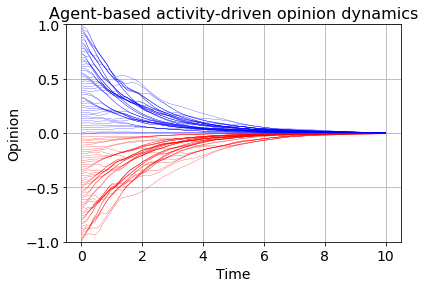

In [83]:
# Plot results:

# Globally change font size for Matplotlib plots
plt.rcParams.update({'font.size': 14})

# Get time values for plotting out of storage array information
time_finish = len(opinionStorage)*dt
time_0 = 0
times = np.arange(time_0, time_finish, dt)

# Plot each agent via looping over storage array
for i in range(len(opinionStorage.T)):
    # In case the last value of agent i is negative, the graph color will be changed to red 
    if opinionStorage.T[i][-1] < 0:
        color = 'r'
    else:
        color ='b'   
    plt.plot(times, opinionStorage.T[i], color, linewidth=.25)

plt.xlabel('Time')
plt.ylabel('Opinion')
plt.title('Agent-based activity-driven opinion dynamics', size=16)
plt.grid()
plt.ylim([-1, 1])
#plt.xticks([0, 5, 10])
#plt.yticks([-5, 0, 5])

# Uncomment if you do want to save the figure:
plot_name = 'Plot--N='+str(N)+'--alpha='+str(alpha_current)+'--beta='+str(beta_current)+'.png'
plt.savefig(plot_name)
plt.show()
